# FuseTS - MOGPR Multi Source Fusion openEO Workflow

In this notebook, we'll demonstrate how to use openEO's diverse capabilities to build a workflow for fusing data. In this particular case, we'll integrate both FuseTS's MOGPR service to fuse a datacube that contains multiple data sources. In this example, we'll be chosing Sentinel 2 NDVI and S1 Coherence data.

**Prerequisites**
- In this notebook, we utilize openEO to retrieve time series data. To leverage the full range of openEO features, you can create a free trial account on the [openEO Platform](https://docs.openeo.cloud/join/free_trial.html) and receive 1000 free credits, enabling you to execute the functionalities showcased in this notebook.


Lets start with importing the different libraries that we need within this notebook.


## Setting up the environment

First of all we need to make sure that all our dependencies are correctly installed.


In [1]:
!pip install openeo


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:

import json
import warnings

import numpy as np
import pandas as pd

import openeo
from openeo.rest.conversions import timeseries_json_to_pandas

import xarray

import matplotlib.pyplot as plt

from ipyleaflet import GeoJSON, Map, basemaps

warnings.filterwarnings("ignore")

# Exploring the area of interest
In this first part, we will explore the area of interest that will be used for calculating the phenology metrics.

In [4]:
year = 2023
spat_ext = {
    "type": "Polygon",
    "coordinates": [
        [
            [
                5.170012098271149,
                51.25062964728295
            ],
            [
                5.17085904378298,
                51.24882567194015
            ],
            [
                5.17857421368097,
                51.2468515482926
            ],
            [
                5.178972704726344,
                51.24982704376254
            ],
            [
                5.170012098271149,
                51.25062964728295
            ]
        ]
    ]
}
temp_ext = [f"{year}-01-01", f"{year}-12-01"]

Plot the area to see what we're working with.


In [5]:
center = np.mean(spat_ext["coordinates"][0], axis=0).tolist()[::-1]
zoom = 16

m = Map(basemap=basemaps.Esri.WorldImagery, center=center, zoom=zoom)
g = GeoJSON(
    data=spat_ext,
    style={
        "color": "red",
        "opacity": 1,
        "weight": 1.9,
        "dashArray": "9",
        "fillOpacity": 0.5,
    },
)
m.add(g)
m

Map(center=[51.249352711712234, 5.173686031746518], controls=(ZoomControl(options=['position', 'zoom_in_text',…

# Setting up connection with openEO

The first step in setting up the workflow, is creating a connection with openEO. 

In [6]:
connection = openeo.connect("openeo.vito.be").authenticate_oidc()

Authenticated using refresh token.


# Creating the input data cube

In the following section, we will leverage the capabilities of openEO to create a datacube that contains multiple data sources

First we start creating a datacube that represents the NDVI values to be calculated.

In [7]:
base_s2 = connection.load_collection('SENTINEL2_L2A',
                                     spatial_extent=spat_ext,
                                     temporal_extent=temp_ext,
                                     bands=["B04", "B08", "SCL"])
base_s2 = base_s2.process("mask_scl_dilation", data=base_s2, scl_band_name="SCL")
base_s2 = base_s2.ndvi(red="B04", nir="B08", target_band='NDVI')
base_s2 = base_s2.filter_bands(bands=['NDVI'])
base_s2 = base_s2.mask_polygon(spat_ext)

The second datacube will contain the RVI data for the given temporal and spatial extent.

In [8]:
base_s1 = connection.load_collection('SENTINEL1_GRD',
                                     spatial_extent=spat_ext,
                                     temporal_extent=temp_ext,
                                     bands=["VH", "VV"])

VH = base_s1.band("VH")
VV = base_s1.band("VV")
base_s1 = (VH + VH) / (VV + VH)
base_s1 = base_s1.add_dimension(name="bands", label="RVI",type="bands")

Next we merge the two datacubes.

In [9]:
merged_datacube = base_s2.merge(base_s1)

# Downloading the original timeseries values
Before continuing with the data fusion step, we download the time series for both the S1 and S2 data. This would allow us to later compare the raw values with the fused data set.

In [10]:
base_s2 = base_s2.aggregate_spatial(spat_ext, reducer='mean')
base_s2.download('./mogpr-multisource-s2-base.json', format='json')

In [11]:
base_s1 = base_s1.aggregate_spatial(spat_ext, reducer='mean')
base_s1.download('./mogpr-multisource-s1-base.json', format='json')

# Executing the MOGPR function
The input data cube is now passed to the MOGPR function. Additionally, we also calculate the mean timeseries values for the given area of interest.

In [12]:
service = 'mogpr'
namespace = 'u:fusets'
mogpr = connection.datacube_from_process(service,
                                         namespace=f'https://openeo.vito.be/openeo/1.1/processes/{namespace}/{service}',
                                         data=merged_datacube)

# Downloading the results
Now that we've setup our workflow, we can now download the results by starting an openEO batch job.

In [13]:
mogpr_output_file = './mogpr-multisource.nc'

In [14]:
mogpr_job = mogpr.execute_batch(mogpr_output_file, out_format="netcdf",
                                title=f'FuseTS - MOGPR - Multi Source', job_options={
        'executor-memory': '8g',
        'udf-dependency-archives': [ 
            'https://artifactory.vgt.vito.be:443/artifactory/auxdata-public/ai4food/fusets_venv.zip#tmp/venv',
            'https://artifactory.vgt.vito.be:443/artifactory/auxdata-public/ai4food/fusets.zip#tmp/venv_static'
        ]
    })

0:00:00 Job 'j-2312141e96e747528c195bf8569c05db': send 'start'
0:00:35 Job 'j-2312141e96e747528c195bf8569c05db': queued (progress N/A)
0:00:40 Job 'j-2312141e96e747528c195bf8569c05db': queued (progress N/A)
0:00:47 Job 'j-2312141e96e747528c195bf8569c05db': queued (progress N/A)
0:00:55 Job 'j-2312141e96e747528c195bf8569c05db': queued (progress N/A)
0:01:05 Job 'j-2312141e96e747528c195bf8569c05db': queued (progress N/A)
0:01:18 Job 'j-2312141e96e747528c195bf8569c05db': queued (progress N/A)
0:01:34 Job 'j-2312141e96e747528c195bf8569c05db': queued (progress N/A)
0:01:54 Job 'j-2312141e96e747528c195bf8569c05db': queued (progress N/A)
0:02:18 Job 'j-2312141e96e747528c195bf8569c05db': queued (progress N/A)
0:02:48 Job 'j-2312141e96e747528c195bf8569c05db': running (progress N/A)
0:03:26 Job 'j-2312141e96e747528c195bf8569c05db': running (progress N/A)
0:04:13 Job 'j-2312141e96e747528c195bf8569c05db': running (progress N/A)
0:05:11 Job 'j-2312141e96e747528c195bf8569c05db': running (progress N/

# Explore the results¶

In [15]:
cubes_dfs = []
ds = xarray.load_dataset(mogpr_output_file)
for var in ds.data_vars.items():
    if var[0] != 'crs':
        var_df = var[1].mean(dim=['x', 'y'])
        var_df = var_df.to_dataframe()
        var_df.index = pd.to_datetime(var_df.index)
        var_df['date'] = var_df.index.date
        var_df = var_df.set_index('date')
        cubes_dfs.append(var_df)

In [16]:
cols = ['RVI - Raw', 'NDVI - Raw']
for result in ['mogpr-multisource-s1-base.json', 'mogpr-multisource-s2-base.json']:
    with open(result, 'r') as result_file:
        df = timeseries_json_to_pandas(json.load(result_file))
        df.index = pd.to_datetime(df.index).date
        cubes_dfs.append(df)
        result_file.close()

joined_df = pd.concat(cubes_dfs, axis=1)
joined_df = joined_df.rename(columns={0: cols[0], 1: cols[1]})

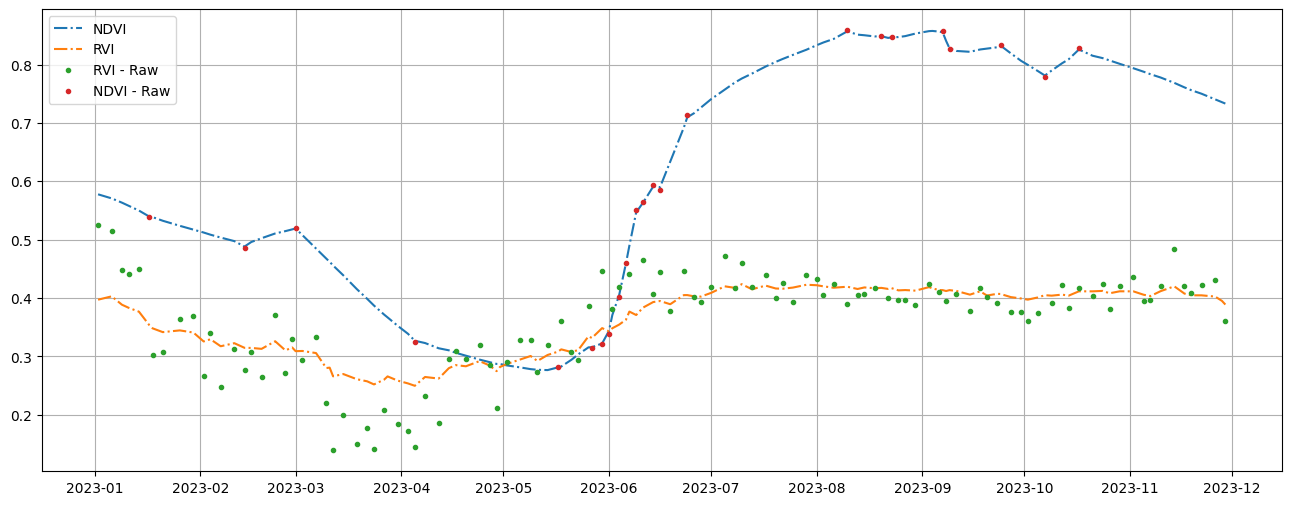

In [17]:
plt.figure(figsize=(16, 6))
for col in joined_df.columns. values:
    values = joined_df[~joined_df[col].isna()]
    plt.plot(values.index, values[col], '.' if 'Raw' in col else '-.', label=col)
plt.grid(True)
plt.legend()